In [1]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
from datetime import datetime

#scraping
import GetOldTweets3 as got
import time

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get Twitter data through web-scraping

In [2]:
def get_tweets(text_query, start_date, end_date, lang, location, within):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                          .setSince(start_date)\
                          .setUntil(end_date)\
                          .setLang(lang)\
                          .setNear(location)\
                          .setWithin(within)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    tw_df = pd.DataFrame(text_tweets, 
                         columns = ['User', 'Text', 'Date', 'Retweets', 'Favorites', 'HashTags'])
    
    return tw_df

We selected 10 cities which have large population and the number of confirmed cases of their county is large.  
This is based on data from JHU on 2020-04-13.
  
Selected cities:  
New York City, New York  (New York county 103208 1st)  
Boston, Massachusetts  (Suffolk county 20934 20th)    
Chicago, Illinois  (Cook county 14585 5th)  
Detroit, Michigan  (Wayne county 11164 6th)  
Los Angeles, California  (Los Angeles county 8894 8th)  
Houston, Texas  (Harris county 3747 26th)  
Newark, New Jersey  (Essex county 7410 11th)  
Miami, Florida  (Miami-dade county 7058 12th)  
Philadelphia, Pennsylvania  (Philadelphia county 6386 13th)  
New Orleans, Louisiana	(Orleans county 5600 17th)  
  
Reference for population: http://www.citymayors.com/gratis/uscities_100.html    

In [4]:
# set attributes needed for get_tweets
text_query = '#StayHome'
start_date = '2020-03-05'
end_date = '2020-04-12'
lang = 'en'
within = '50mi'

citys = ['New York City, New York','Boston, Massachusetts','Chicago, Illinois','Detroit, Michigan','Los Angeles, California','Houston, Texas','Newark, New Jersey','Miami, Florida','Philadelphia, Pennsylvania','New Orleans, Louisiana']# export our raw data

In [5]:
# scrap needed info and export to csv file
for city in citys:
    location = city
    df = get_tweets(text_query, start_date, end_date, lang, location, within)
    df.to_csv(city + '.csv', index = False)
    time.sleep(120)

In [6]:
# add 'City' column and combine all datasets
city_column = ['NY', 'BOSTON', 'CHI', 'DETROIT', 'LA', 'HOUSTON', 'NEWARK', 'MIA', 'PHIL', 'NEW ORLEANS']
stayhome = pd.DataFrame()
for i in range(len(city_column)):
    df = pd.read_csv(citys[i] + '.csv')
    df['City'] = city_column[i]
    stayhome = pd.concat([stayhome, df], axis = 0)

In [7]:
# export our raw data
stayhome.to_csv('StayHome.csv', index = False)

# Stratified Sampling for Raw Data

In [25]:
# import data
df = pd.read_csv("StayHome.csv")
df.shape

(30282, 7)

In [26]:
# remove duplicates
df.replace('[]', np.nan,inplace=True)
df.drop_duplicates(inplace =True)
df.drop_duplicates(subset = ['Text'],inplace =True)

# devide timestamp into date and time
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].apply( lambda x: x.strftime("%Y-%m-%d"))
df['time'] = df['Date'].apply( lambda x: x.strftime("%H-%M-%S"))
df.drop(['Date'],axis = 1, inplace =True)

# replace city initials with city names
replace_values = {'NY' : 'New York', 'BOSTON' : 'Boston', 'CHI' : 'Chicago', 'DETROIT' : 'Detroit', 'HOUSTON' : 'Houston',
                  'LA' : 'Los Angeles', 'MIA' : 'Miami', 'NEWARK' : 'Newark', 'NEW ORLEANS' : 'New Orleans', 'PHIL' : 'Philadelphia'}                                                                                          
df = df.replace({"City": replace_values})  

In [27]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]

In [28]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis = 1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-04-02,426,483,1.133803,4543,260
2020-04-03,432,493,1.141204,4800,257
2020-04-04,389,450,1.156812,5042,242
2020-04-05,445,510,1.146067,5265,223
2020-04-06,1835,2008,1.094278,5513,248
2020-04-07,1904,2182,1.146008,7129,1616
2020-04-08,2199,2476,1.125966,8635,1506
2020-04-09,2150,2475,1.151163,10280,1645
2020-04-10,2153,2462,1.143521,11791,1511


Raw data is imbalanced in user number.

In [29]:
# select '2020-04-06' as division
# old users: who started to be active before 04-06
# new_users: who weren't active until 04-06
existing_user= df[df['date'] < '2020-04-06']['User'].unique()

# retain all old users
df1 = df[df['User'].isin(existing_user)]                      
df2 = df[-df['User'].isin(existing_user)]

# sample new users
df2 = df2.sample(1300)

# get new sample
df = pd.concat([df1,df2])                                     

# export new sample
df.to_csv("StayHome_final.csv", index = False)
df.shape

(11631, 8)

[Text(0, 0, '2020-03-05'),
 Text(0, 0, '2020-03-08'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-03-10'),
 Text(0, 0, '2020-03-11'),
 Text(0, 0, '2020-03-12'),
 Text(0, 0, '2020-03-13'),
 Text(0, 0, '2020-03-14'),
 Text(0, 0, '2020-03-15'),
 Text(0, 0, '2020-03-16'),
 Text(0, 0, '2020-03-17'),
 Text(0, 0, '2020-03-18'),
 Text(0, 0, '2020-03-19'),
 Text(0, 0, '2020-03-20'),
 Text(0, 0, '2020-03-21'),
 Text(0, 0, '2020-03-22'),
 Text(0, 0, '2020-03-23'),
 Text(0, 0, '2020-03-24'),
 Text(0, 0, '2020-03-25'),
 Text(0, 0, '2020-03-26'),
 Text(0, 0, '2020-03-27'),
 Text(0, 0, '2020-03-28'),
 Text(0, 0, '2020-03-29'),
 Text(0, 0, '2020-03-30'),
 Text(0, 0, '2020-03-31'),
 Text(0, 0, '2020-04-01'),
 Text(0, 0, '2020-04-02'),
 Text(0, 0, '2020-04-03'),
 Text(0, 0, '2020-04-04'),
 Text(0, 0, '2020-04-05'),
 Text(0, 0, '2020-04-06'),
 Text(0, 0, '2020-04-07'),
 Text(0, 0, '2020-04-08'),
 Text(0, 0, '2020-04-09'),
 Text(0, 0, '2020-04-10'),
 Text(0, 0, '2020-04-11')]

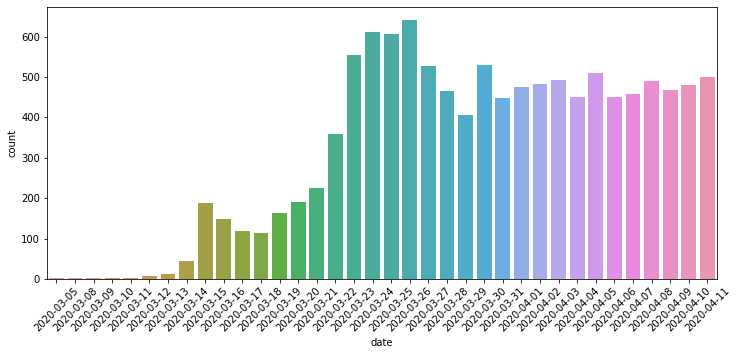

In [30]:
# plot the distribution of our new sample
fig = plt.figure(figsize = (12,5))
chart = sns.countplot(df['date'], order = sorted(df['date'].unique()))
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

In [33]:
# count number of unique users for different time period
dates = sorted(df['date'].unique())
unique_user = list()
for date in dates: 
    unique_user.append(df[df['date'] < date]['User'].nunique())

lag_user = [0]+unique_user 
lag_user = lag_user[:-1]

In [34]:
# calculate users per day
user1 = pd.DataFrame(df.groupby('date')['User'].nunique())
user2 = pd.DataFrame(df.groupby('date')['Text'].nunique())
user = pd.concat([user1,user2],axis =1)
user['num_of_text_per_capita'] = user['Text']/user['User']
user['total_unique_user'] = unique_user
user['lag_user'] = lag_user
user['new_user'] = user['total_unique_user']-user['lag_user']
user.drop(['lag_user'],axis =1, inplace = True)
user.tail(10)

,User,Text,num_of_text_per_capita,total_unique_user,new_user
date,,,,,
2020-04-02,426,483,1.133803,4543,260
2020-04-03,432,493,1.141204,4800,257
2020-04-04,389,450,1.156812,5042,242
2020-04-05,445,510,1.146067,5265,223
2020-04-06,406,451,1.110837,5513,248
2020-04-07,401,457,1.139651,5700,187
2020-04-08,440,489,1.111364,5887,187
2020-04-09,411,468,1.138686,6107,220
2020-04-10,418,481,1.150718,6311,204


The new dataset is balanced in user numbers.